## Import libraries. 

In [1]:
# Python Libraries
import  os;
from    typing              import  List, Dict, Tuple;

# External libraries. 
import  numpy;
import  matplotlib.pyplot       as      plt;
import  matplotlib              as      mpl;
import  seaborn;
import  torch;
from    torch.utils.tensorboard import  SummaryWriter;
from    scipy                   import  interpolate;

# Set up the TensorBoard SummaryWriter
Base_Dir    : str   = "./Logs";
Counter     : int   = 0;
Log_Dir     : str   = os.path.join(Base_Dir, "Version_" + str(Counter));
while(os.path.isdir(Log_Dir) == True):
    Counter += 1;
    Log_Dir  = os.path.join(Base_Dir, "Version_" + str(Counter));
TB_Writer = SummaryWriter(log_dir = Log_Dir);

## Import my code

### Model Class

Define a class that can describe the right-hand side of a DDE, 
$$x'(t) = F(x(t), y(t), t) $$

In our case, the right-hand side we want to learn will be
1. $F(x, y, t) = x(1 - y) $
2. $F(x, y, t) = \sin{x}$

The `Model` class defines an object that can act like the function $F$.

### DDE Solver

This is an algorithm to solve a DDE of the following form:
$$\begin{aligned} x'(t) &= F(x(t), x(t - \tau), t) \qquad t \in [0, T] \\
x(t) &= x_0 \qquad \qquad \qquad \qquad \quad  t \in [-\tau, 0] \end{aligned}$$

We find an approximate solution using a forward euler solver for DDEs.

### NDDE class

Here we define the `NDDE_1D` class. This class acts as a wrapper around a `Model` object. Recall that a `Model` object acts like the function $F$ in the following DDE:
$$\begin{aligned} x'(t) &= F(x(t), x(t - \tau), t) \qquad t \in [0, T] \\
x(t) &= x_0 \qquad \qquad \qquad \qquad \quad  t \in [-\tau, 0] \end{aligned}$$
The `NDDE_1D` class accepts a `Model`. Its forward method solves the implied DDE on the interval $[0, T]$ and then returns the result.

### Loss

Here, we implement the loss functions that we try to minimize. 

In [2]:
from    Model   import  Logistic_Model      as Model;
from    Solver  import  RK2                 as DDE_Solver;
from    NDDE    import  NDDE;
from    Train   import  Train;
from    Utils   import  Initialize_Logger, Initialize_MPL;
from    Loss    import  l, G, Integral_Loss;

# logger setup.
import  logging;

Initialize_Logger(level = logging.INFO);
LOGGER : logging.Logger = logging.getLogger(__name__);

# plot setup. 
Initialize_MPL();

### Generate Target Trajectory

Generate the target trajectory and plot it!

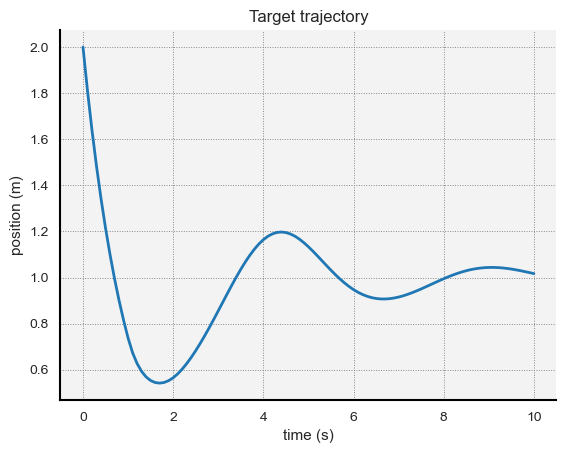

In [3]:
# Set up the parameters and tau value for the target trajectory.
F_Target        = Model(theta_0 = 1.0, theta_1 = 1.0);
x0_Target       = torch.tensor([2.0]);
tau_Target      = torch.tensor(1.0);
T_Target        = torch.tensor(10.0);

# Get the target trajectory!
x_Target, t_Target  = DDE_Solver(F = F_Target, x0 = x0_Target, tau = tau_Target, T = T_Target);

# Finally, lets plot the target trajectory.
seaborn.lineplot(x = t_Target, y = x_Target.reshape(-1).detach().numpy());
seaborn.despine();
plt.xlabel("time (s)");
plt.ylabel("position (m)");
plt.title("Target trajectory");

### Setup, train the Model 


In [5]:
# Settings for training
N_Epochs        : int       = 1000;
Learning_Rate   : float     = 0.1;
Loss_Threshold  : float     = 0.001;             # Will exit when loss drops below this.

# Set up a NDDE object. We will try to train the enclosed model to match the one we used to generate the above plot.
MODEL       = Model(theta_0 = 1.75, theta_1 = 1.75);
DDE_Module  = NDDE(MODEL);

# Pick a starting position, tau, and x0
tau     = torch.tensor(1.75,     requires_grad = True);
x0      = torch.clone(x0_Target + 1.0).requires_grad_(True);
T       = torch.clone(T_Target).requires_grad_(False);

# Select the optimizer, number of epochs.
Param_List  : List  = list(MODEL.parameters()) + [tau, x0];
Optimizer           = torch.optim.Adam(Param_List, lr = Learning_Rate);
Scheduler           = torch.optim.lr_scheduler.CosineAnnealingLR(
                                            optimizer   = Optimizer, 
                                            T_max       = N_Epochs, 
                                            eta_min     = Learning_Rate/10.);

# Train!
t_Predict, x_Predict  = Train(  DDE_Module      = DDE_Module, 
                                x0              = x0, 
                                tau             = tau, 
                                T               = T, 
                                N_Epochs        = N_Epochs, 
                                x_Target        = x_Target, 
                                t_Target        = t_Target, 
                                l               = l,
                                G               = G,
                                Loss_Threshold  = Loss_Threshold, 
                                Optimizer       = Optimizer, 
                                Scheduler       = Scheduler,
                                Writer          = TB_Writer);

  10:   Loss = 52.04201  | tau = 1.29390  | grad tau =  -1.59011
  20:   Loss = 62.40417  | tau = 1.02722  | grad tau =   4.41268
  30:   Loss = 34.47921  | tau = 0.60641  | grad tau =   1.36051
  40:   Loss = 20.27811  | tau = 0.35360  | grad tau =  -0.32273
  50:   Loss = 26.08429  | tau = 0.28158  | grad tau =  -0.28561
  60:   Loss = 19.47182  | tau = 0.27650  | grad tau =  -0.05243
  70:   Loss = 19.41815  | tau = 0.28026  | grad tau =  -0.02827
  80:   Loss = 18.65854  | tau = 0.28585  | grad tau =  -0.06714
  90:   Loss = 16.87166  | tau = 0.29765  | grad tau =  -0.12664
 100:   Loss = 14.88158  | tau = 0.32042  | grad tau =  -0.20793
 110:   Loss = 12.23601  | tau = 0.35970  | grad tau =  -0.30579
 120:   Loss = 9.03131  | tau = 0.42009  | grad tau =  -0.40660
 130:   Loss = 5.79189  | tau = 0.50531  | grad tau =  -0.51749
 140:   Loss = 3.10158  | tau = 0.61666  | grad tau =  -0.56716
 150:   Loss = 1.36143  | tau = 0.74515  | grad tau =  -0.53105
 160:   Loss = 0.49867  | tau

### Plot results 

We plot the loss history, final vs true trajectory, and the loss function for fixed parameter values as a function of $\tau$

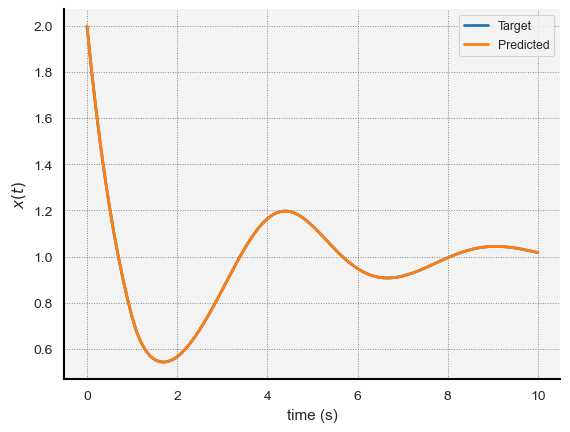

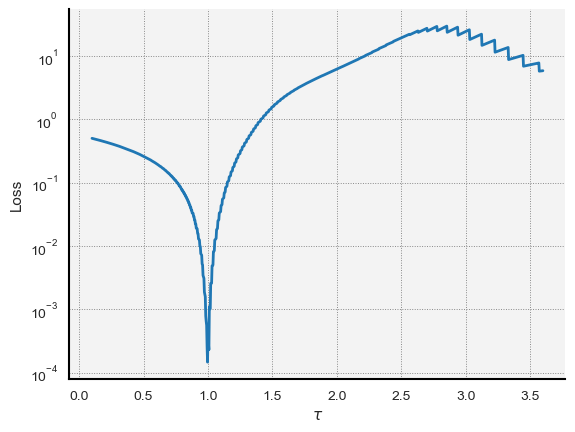

In [5]:
####################################################################################################
# Plot target, final trajectory

plt.figure(1);
plt.plot(t_Target,  x_Target[0].detach().numpy(),      label = "true");
plt.plot(t_Predict, x_Target[0].detach().numpy(),   label = "discovered");
seaborn.despine();
plt.xlabel("time (s)");
plt.ylabel(r"$x(t)$");
plt.legend(["Target","Predicted"]);



####################################################################################################
# Plot loss as a function of tau

# Build initial model
G = Model(theta_0 = 1.0, theta_1 = 1.0);

# Set up a grid of tau values. We will find the loss at each one.
N_Steps : int = 1000;
grid_tau = torch.linspace(0.1, 3.6, steps = N_Steps, requires_grad = True);
Loss_tau = torch.zeros(N_Steps);

for i in range(N_Steps):
    # Find predictions for ith tau value.
    Predictions_i : torch.Tensor = DDE_Solver(G, x0, grid_tau[i], T)[0];

    # Interpolate true solution on the time step grid for this solution.
    N_i                 : int           = Predictions_i.shape[1];
    x_Interp                            = interpolate.interp1d(t_Target.detach().numpy(), x_Target.detach().numpy());
    t_Values            : numpy.ndarray = numpy.linspace(start = 0, stop = T.item(), num = N_i);
    Targets_i           : torch.Tensor  = torch.from_numpy(x_Interp(t_Values));
    
    # Compute loss
    Loss_tau[i] = Integral_Loss(Predictions_i, Targets_i, t_Values);

# Plot!
plt.figure(2);
seaborn.lineplot(x = grid_tau.detach().numpy(), y = Loss_tau.detach().numpy());
seaborn.despine();
plt.xlabel(r"$\tau$");
plt.ylabel("Loss");
plt.yscale("log");